# Data Exploration

## Overview

In this section we will perform a first overview on wine dataset.
It's hard to know what to do if you don't know what you're working with, so let's load our dataset and take a peek. We will try to figure out the dataset size, number of features and the column types (features + target).

In [1]:
import numpy as np
import pandas as pd
from time import time

%matplotlib inline

# Read student data
data = pd.read_csv("data.csv", delimiter=";")
print("Data read successfully!")

# Calculate number of wines in dataset
n_wines = data.shape[0]

# Calculate number of features
n_features = data.shape[1] - 1

# Print the results
display(data.head())

print("Total number of wines: {}".format(n_wines))
print("Number of features: {}".format(n_features))


Data read successfully!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Total number of wines: 6497
Number of features: 12


**Attribute types**:

We have the following column types in the dataset:
  - `type`: Categorical (nominal)
  - `fixed acidity`: Numeric (continuous)
  - `volatile acidity`: Numeric (continuous)
  - `citric acid`: Numeric (continuous)
  - `residual sugar`: Numeric (continuous)
  - `chlorides`: Numeric (continuous)
  - `free sulfur dioxide`: Numeric (continuous)
  - `total sulfur dioxide`: Numeric (continuous)
  - `density`: Numeric (continuous)
  - `pH`: Numeric (continuous)
  - `sulphates`: Numeric (continuous)
  - `alcohol`: Numeric (continuous)
  - `quality`: Numeric (ordinal)



## Outliers
TODO

## Scaling
TODO

In [2]:
# from sklearn.preprocessing import MinMaxScaler, scale
# scaler = MinMaxScaler()
# feat = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
# X_all[feat] = scale(X_all[feat])
# display(X_all.head())

## Preparing data

In this section, we will prepare the data for modeling, training and testing.

## Separete feature and target columns

It is often the case that the data contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

The code cell below will separate the wine data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(data.columns[:-1])

# Extract target column 'quality'
target_col = data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data[feature_cols]
y_all = data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all.head())

print("\nFeature types")
print(X_all.dtypes)

print("\nClasses from type feature:")
print(data['type'].unique())

Feature columns:
['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Target column: quality

Feature values:


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9



Feature types
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
dtype: object

Classes from type feature:
['White' 'Red']


## Preprocess features

As we can see, there two non-numeric features that need to be converted: `type` and `alcohol`.

The `type` feature only has two classes (`['White' 'Red']`), so it can be reasonably converted into 1/0 (binary) values.

The `alcohol` feature is actually a numeric feature, but some rows are wrong non-numeric values, for example `'110.666.666.666.667'`, `'956.666.666.666.667'`, `'923.333.333.333.333'` and so on. Therefore, we will parse the values of this feature into numeric values and replace the wrong values with the mean of all of the values for the feature ([reference](https://machinelearningmastery.com/handle-missing-data-python/)).

The code cell below performs the preprocessing routine discussed in this section.
 


In [4]:

def preprocess_features(X):
    ''' Preprocesses the data and converts non-numeric binary variables into
        binary (0/1) variables.'''

    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If type, replace all 'White'/'Red' values with 1/0
        if col == 'type' and col_data.dtype == object:
            col_data = col_data.replace(['White', 'Red'], [1, 0])
        
        # If alcohol, parse it values to numberic and coerce the convertion errors
        if col == 'alcohol' and col_data.dtype == object:
            col_data = pd.to_numeric(col_data, errors='coerce')

        # Collect the revised columns
        output = output.join(col_data)

    # handle NaN values by inputting the mean
    output.fillna(output.mean(), inplace=True)
    
    return output

X_all = preprocess_features(X_all)

## Feature scaling

At this point, we've successfully cleaned our data and converted it into a form which is easily consumable by machine learning algorithms. However, at this point we should consider whether or not some method of data normalization / scaling will be beneficial for our algorithm. Feature scaling allows for all features to contribute equally (or more aptly, it allows for features to contribute relative to their importance rather than their scale). The code cell below plots the boxplot for all features in dataset.

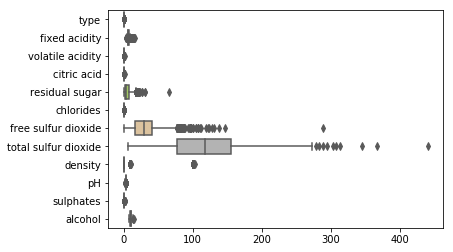

In [5]:
import seaborn as sns
sns.boxplot(data=X_all, orient="h", palette="Set2")

As we can see, the range of values varies widely between the features. Therefore, we will apply min-max normalization in all features so that each feature contributes proportionately in the same scale in the models. After transformation the new feature takes on values in the range \[0,1\].


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_features(X):
    X = X.copy()
    scaler = MinMaxScaler()
    features = list(X_all.select_dtypes(include=['float64']).columns)
    print(features, scaler)
    X[features] = scaler.fit_transform(X_all[features])
    print(X[features].head())
    return X

def scale_features2(X):
    X = X.copy()
    scaler = StandardScaler()
    features = list(X_all.select_dtypes(include=['float64']).columns)
    print(features, scaler)
    X[features] = scaler.fit_transform(X_all[features])
    print(X[features].head())
    return X

X_scaled = scale_features(X_all)
X_scaled2 = scale_features2(X_all)
display(X_all.head())
display(X_scaled.head())
display(X_scaled2.head())

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] MinMaxScaler(copy=True, feature_range=(0, 1))
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.264463          0.126667     0.216867        0.308282   0.059801   
1       0.206612          0.146667     0.204819        0.015337   0.066445   
2       0.355372          0.133333     0.240964        0.096626   0.068106   
3       0.280992          0.100000     0.192771        0.121166   0.081395   
4       0.280992          0.100000     0.192771        0.121166   0.081395   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.152778              0.377880  0.000135  0.217054   0.129213   
1             0.045139              0.290323  0.000067  0.449612   0.151685   
2             0.100694              0.209677  0.000078  0.418605   0.123596 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.000135,0.217054,0.129213,0.115942
1,1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.000067,0.449612,0.151685,0.217391
2,1,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.000078,0.418605,0.123596,0.304348
3,1,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.000082,0.364341,0.101124,0.275362
4,1,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.000082,0.364341,0.101124,0.275362


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,-0.166089,-0.423183,0.284686,3.206929,-0.314975,0.815565,0.959976,-0.092971,-1.359049,-0.546178,-1.420364
1,1,-0.706073,-0.240949,0.147046,-0.807837,-0.200790,-0.931107,0.287618,-0.093888,0.506915,-0.277351,-0.831728
2,1,0.682458,-0.362438,0.559966,0.306208,-0.172244,-0.029599,-0.331660,-0.093744,0.258120,-0.613385,-0.327183
3,1,-0.011808,-0.666161,0.009406,0.642523,0.056126,0.928254,1.243074,-0.093678,-0.177272,-0.882212,-0.495365
4,1,-0.011808,-0.666161,0.009406,0.642523,0.056126,0.928254,1.243074,-0.093678,-0.177272,-0.882212,-0.495365


## Data balancing

A very frequent problem in machine learning models is imbalanced dataset, because an imbalanced dataset may lead to inflated performance estimates ([reference](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data)). Therefore, We will analyse if the dataset response variable is balalanced or not.

Plot for the counts of observations in each quality using bars.


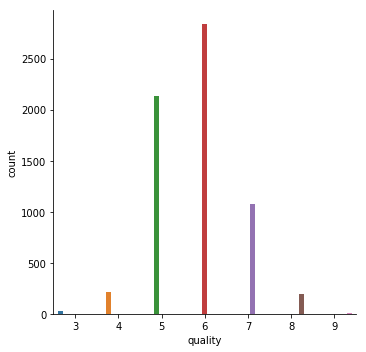

In [7]:
print("Plot for the counts of observations in each quality using bars.")
#sns.catplot("quality", data=data, hue='quality', kind="count")
sns.catplot("quality", data=data, hue='quality', kind="count")

As we can see, the response variable `quality` is unbalanced and probably we'll have to handle it later.

## Training and Testing Data

We have converted all categorical features into numeric values.
Now, we will split the data (both features and corresponding labels) into training and test sets.
In the following code cell below, you will need to implement the following:

- Randomly shuffle and split the data (X_all, y_all) into training and testing subsets.
- Use approximately 75% for training set and approximately 25% for testing set.
- Set a random_state for the function(s) you use, if provided.
- Store the results in X_train, X_test, y_train, and y_test.

In [8]:
from sklearn.model_selection import train_test_split

# Set the number of training points
num_train = int(X_all.shape[0] * 0.75)

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    train_size=num_train,
    test_size=num_test,
    random_state=42,
    #stratify=y_all  #  EXTRA: preserve class imbalance
)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("Show if the quality classes rate is preserved across the sets")
cls_props = pd.DataFrame(data={
    'original': data['quality'].value_counts() / data['quality'].shape[0],
    'training': y_train.value_counts() / y_train.shape[0],
    'testing': y_test.value_counts() / y_test.shape[0]
})
cls_props.index.name = 'class'
display(cls_props)

# sns.catplot(data=df, kind="count");

Training set has 4872 samples.
Testing set has 1625 samples.
Show if the quality classes rate is preserved across the sets


,original,testing,training
class,,,
3,0.004618,0.003077,0.005131
4,0.033246,0.032615,0.033456
5,0.329075,0.323077,0.331076
6,0.436509,0.451692,0.431445
7,0.166077,0.165538,0.166256
8,0.029706,0.024000,0.031609
9,0.000770,NaN,0.001026


## Training and Evaluating Models

In this section, we will choose 3 supervised learning models that are appropriate for this problem and available in scikit-learn.

The code cell below initializes three helper functions which we can use for training and testing the three supervised learning models we've chosen. The functions are as follows:

- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs train_clasifier and predict_labels.




In [9]:
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

## Model Performance Metrics
With the predefined functions above, we will now import the three supervised learning models of our choice and run the train_predict function for each one. We will train and predict on each classifier for four different training set sizes: 25%, 50%, 75% and 100%. Hence, we should expect to have 12 different outputs below — 4 for each model using the varying training set sizes.

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = KNeighborsClassifier(n_neighbors=1)
clf_C = RandomForestClassifier(n_estimators=100)
clf_D = BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
clf_E = LinearDiscriminantAnalysis()
clf_F = LinearSVC(random_state=0)
clf_G = LogisticRegressionCV(random_state=0, multi_class='multinomial')
clf_H = SVC(gamma='auto')
clf_I = MLPClassifier()
clf_J = GradientBoostingClassifier()

size = X_train.shape[0]

# Execute the 'cross_val_score' function for each classifier and each training set size 25% 50% 75% 100%
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I, clf_J]:
   print("\n[{}]\n".format(clf.__class__.__name__))
   for n in [int(size * 0.25), int(size * 0.50), int(size * 0.75), size]:
       cv_scores = cross_val_score(clf, X_all[:n], y_all[:n], cv=3)
       cv_scores2 = cross_val_score(clf, X_scaled[:n], y_all[:n], cv=3)
       cv_scores3 = cross_val_score(clf, X_scaled2[:n], y_all[:n], cv=3)
    
       print("data size {} and mean score 1 {}, mean score 2 {}, mean score 3 {}".format(n, np.mean(cv_scores), np.mean(cv_scores2), np.mean(cv_scores2)))


[DecisionTreeClassifier]

data size 1218 and mean score 1 0.378451033309648, mean score 2 0.3768252151207587, mean score 3 0.3768252151207587
data size 2436 and mean score 1 0.3805354907097754, mean score 2 0.38053449578087073, mean score 3 0.38053449578087073
data size 3654 and mean score 1 0.3979316433516112, mean score 2 0.3968385252507807, mean score 3 0.3968385252507807
data size 4872 and mean score 1 0.4021013284789812, mean score 2 0.39778819781358354, mean score 3 0.39778819781358354

[KNeighborsClassifier]

data size 1218 and mean score 1 0.3653140669036478, mean score 2 0.4211320183018012, mean score 3 0.4211320183018012
data size 2436 and mean score 1 0.364126148208816, mean score 2 0.3994129293118068, mean score 3 0.3994129293118068
data size 3654 and mean score 1 0.37986517385547547, mean score 2 0.42391799073154585, mean score 3 0.42391799073154585
data size 4872 and mean score 1 0.3928618357284142, mean score 2 0.42345565441920846, mean score 3 0.42345565441920846

[Ran

/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.war

data size 2436 and mean score 1 0.49264929590282286, mean score 2 0.49264929590282286, mean score 3 0.49264929590282286
data size 3654 and mean score 1 0.4865740540851719, mean score 2 0.4865740540851719, mean score 3 0.4865740540851719
data size 4872 and mean score 1 0.5059629845066924, mean score 2 0.5059629845066924, mean score 3 0.5059629845066924

[LinearSVC]



/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.war

data size 1218 and mean score 1 0.17351768862774428, mean score 2 0.45071779707672305, mean score 3 0.45071779707672305


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernan

data size 2436 and mean score 1 0.3998777678164101, mean score 2 0.4935021685098085, mean score 3 0.4935021685098085


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernan

data size 3654 and mean score 1 0.36749456701639255, mean score 2 0.4895981750931883, mean score 3 0.4895981750931883


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/fernan

data size 4872 and mean score 1 0.34629457029508, mean score 2 0.5145960767279889, mean score 3 0.5145960767279889

[LogisticRegressionCV]



/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in ve

/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in ve

data size 1218 and mean score 1 0.4112760558872462, mean score 2 0.45399378028211396, mean score 3 0.45399378028211396


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/

/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number 

data size 2436 and mean score 1 0.47581016839679763, mean score 2 0.502518770233456, mean score 3 0.502518770233456


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number 

data size 3654 and mean score 1 0.4581286969474547, mean score 2 0.4939767191255415, mean score 3 0.4939767191255415


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number 

/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number 

data size 4872 and mean score 1 0.4733396161960866, mean score 2 0.516637242877443, mean score 3 0.516637242877443

[SVC]

data size 1218 and mean score 1 0.41875834207587664, mean score 2 0.40887360976028053, mean score 3 0.40887360976028053
data size 2436 and mean score 1 0.42201338129069965, mean score 2 0.44045098598120647, mean score 3 0.44045098598120647
data size 3654 and mean score 1 0.41898850258336573, mean score 2 0.4510035278413425, mean score 3 0.4510035278413425
data size 4872 and mean score 1 0.4429475224836132, mean score 2 0.47598367948686504, mean score 3 0.47598367948686504

[MLPClassifier]



/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/mul

data size 1218 and mean score 1 0.43017174435496286, mean score 2 0.4630331477077003, mean score 3 0.4630331477077003


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/mul

data size 2436 and mean score 1 0.4610206448656724, mean score 2 0.5021102896572134, mean score 3 0.5021102896572134


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/mul

data size 3654 and mean score 1 0.47017525869637183, mean score 2 0.5043832664104889, mean score 3 0.5043832664104889


/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/fernandofelix/Workspace/cognitivo.ai/wine-test/.env/lib/python3.5/site-packages/sklearn/neural_network/mul

data size 4872 and mean score 1 0.44067783078048234, mean score 2 0.5297735468182766, mean score 3 0.5297735468182766

[GradientBoostingClassifier]

data size 1218 and mean score 1 0.45483484164122, mean score 2 0.45730200012177397, mean score 3 0.45730200012177397
data size 2436 and mean score 1 0.4700914278772233, mean score 2 0.4696870017296583, mean score 3 0.4696870017296583
data size 3654 and mean score 1 0.4846673376941122, mean score 2 0.49069669019760226, mean score 3 0.49069669019760226
data size 4872 and mean score 1 0.5022727019893791, mean score 2 0.5041202482083679, mean score 3 0.5041202482083679
